# Gaussian Model

## Swaption pricing

The swaption price at time 0, $V_0$, is given by the following expression $$
    \begin{array}{ll} V_0 &= \mathbb{E}_{\mathbb{Q}}\Big[e^{-\int_{0}^{T_0} r(s) \ \mathrm{d}s}Swap(T_0)^+\Big] \\
&= P(0,T_0) \ \mathbb{E}_{\mathbb{Q}}\Big[e^{-\int_{0}^{T_0} x(s) \ \mathrm{d}s}\Big(1-P(T_0,T_N,x(T_0),y(T_0))-K\sum_{n=0}^{N-1} \tau_n P(T_0,T_{n+1},x(T_0),y(T_0)\Big)^+\Big]
\end{array}
$$
And $$\forall n \in [|0,N|], \quad P(T_0,T_n,x,y) = \frac{P(0,T_n)}{P(0,T_0)} e^{-G(T_0,T_N)x-\frac{1}{2}G(T_0,T_N)^2 y}$$

One will use a Monte Carlo estimator of the expectation above by using M independent simulations $S_m$ so that
$$\hat{V_0} = \frac{1}{M} \sum_{m=1}^M S_m$$
$$\forall m, \ S_m = e^{I_m} \ \Big(P(0,T_0)-P(0,T_0)P(T_0,T_n,x_m,y_m) - KP(0,T_0) A(T_0,x_m,y_m)\Big)^+$$
Where we have noted $x_m,y_m,I_m$ the m-th Euler simulation of $x(T_0),y(T_0), I(T_0)$

## Euler discretization

We aim to discretize the following differential system with an Euler scheme

$$\left\{
    \begin{array}{ll}
       \mathrm{d}x(t) &= (y(t) - \chi(t) x(t)) \ \mathrm{d}t \ + \ \sigma_r(t) \ \mathrm{d}Wt\\
       \mathrm{d}y(t) &= (\sigma_r(t)^2-2\chi(t)y(t)) \ \mathrm{d}t
    \end{array}
\right.$$

**Constant mean reversion and linear local volatility:** First, let for simplicity $$\chi(t) = \chi \in \mathbb{R}$$ and $$\sigma_r(t) = \sigma_r(t,x(t),y(t)) = \lambda(a + bx(t))$$

One defines a discretized time interval $0=t_0 < t_1 < ... < t_N = T_0$ and $\forall i \in [|0,N-1|], \ \Delta_i = t_{i+1} -t_i$

We will simulate $x(T_O)$ and $y(T_O)$ thanks to the scheme:
$$\left\{
    \begin{array}{ll}
       x_{t_{i+1}} &= x_{t_i} + (y_{t_i} - \chi x_{t_i}) \ \Delta_i \ + \ \lambda(a+bx_{t_i}) \ \sqrt{\Delta_i} Z_i \qquad  ,Z_i \sim \mathcal{N}(0,1) \\
       y_{t_{i+1}} &= y_{t_i} + (\lambda^2(a+bx_{t_i})^2-2\chi y_{t_i}) \ \Delta_i
    \end{array}
\right.$$

What's more, one has to simulate the variable $$I(T_0)=-\int_{0}^{T_0} x(s) \ \mathrm{d}s$$
As $\mathrm{d}I(t) = -x(t) \ \mathrm{d}t$, in line with the results above, one defines
$$I_{t_{i+1}} = I_{t_i} - x_{t_i} \ \Delta_i$$

**Remark:** $y(t) = \int_{0}^{t} e^{-2\chi(t-u)} (a+bx(u))^2 \ \mathrm{d}u$ is a path dependent integral and could be calculated with the values $\{x_{t_i}, \ t_i<t\}$

## Simulation

In order to price swaptions, one needs the values of the zero coupon bonds for each maturity $\Big(P(0,T_i)\Big)_{i=0,N}$. One can calculate it with $$P(0,T_i) = e^{-\int_{0}^{T_i}f(0,u) \ \mathrm{d}u}$$, but one needs again **the initial forward curve** $t \rightarrow f(0,t)$


To do some calculations and to have a first simple approach, I have chosen to fixe $P(0,T) = e^{-rT}$ even if it's completely wrong in our model because the short rate is stochastic.

In [29]:
#modules

import numpy as np
import math
from random import *
from time import time
import scipy.stats as stats
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(10)

def gaussian_density(x):
    return 1/(np.sqrt(2*np.pi))*np.exp(-0.5*x**2)

In [2]:
#Plotting functions

def plot2D(x,y,xlabel,ylabel,title,z=[],zlabel=''):
    plt.figure()
    plt.xlabel(xlabel)
    plt.title(title)
    plt.plot(x,y,label=ylabel)
    if z != []:
        plt.plot(x,z,label=zlabel)
    plt.legend()
    plt.show()
    
def plot3D(X, Y, Z,angle):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('K')
    ax.set_ylabel('T0')
    ax.set_zlabel('vol')
    ax.set_title('Implied vol')
    ax.view_init(40,angle)

In [54]:
# One set the parameters
chi = 1
lmbda = 1
a = 1
b = 1
K = 1
N = 20
M = 100000
r = 1
maturities = np.arange(0.5,5)     #tenor structure of the underlying swap T0=1,2...6=TN
T0 = maturities[0]
bonds = [np.exp(-r*m) for m in maturities]  #P(0,T_i) fixed to exp(-T_i) for tests

In [4]:
#Simulation of the diffusions x,y,I
#delta is the time grid of the discretization

def simul(lmbda,a,b,chi,delta):
    N = delta.size
    (x,y,I) =(0,0,0)
    for i in range(N-1):
        delta_i = delta[i+1]-delta[i]
        sigma_i = lmbda*(a+b*x)
        Z = float(np.random.standard_normal(1))
        I = I - x*delta_i
        x = x +(y-chi*x)*delta_i + sigma_i*math.sqrt(delta_i)*Z
        y = y + (sigma_i**2 -2*chi*y)*delta_i
    return [x,y,I]

In [6]:
#test
delta = np.linspace(0,T0,N+1)
s = simul(lmbda,a,b,chi,delta)
(x,y,I) = (s[0],s[1],s[2])
print(x,y,I)

0.5863740923860796 0.5647822853762721 -0.09893997229349237


In [7]:
#function G 
def G(t,T,chi):
    return (1-np.exp(chi*(t-T)))/chi

#payoff of the swaption at T0
def payoff_swaption(maturities,bonds,x,y,chi,K):
    T0 = maturities[0]                             #maturities = [T0,...,TN]
    nb_maturities = maturities.size
    A = 0
    #calculate the annuity A
    for n in range(nb_maturities-1):
        g = G(T0,maturities[n+1],chi)
        A += (maturities[n+1]-maturities[n])*bonds[n+1]*np.exp(-1*g*x-0.5*y*g**2)
    g = G(T0,maturities[-1],chi)
    swap = bonds[0] - bonds[-1]*np.exp(-1*g*x-0.5*y*g**2) - K*A
    if swap>0:
        return swap
    else:
        return 0

In [8]:
#test

payoff_swaption(maturities,bonds,x,y,chi,K)

0.40599192130027906

In [9]:
#pricing of the swaption by Monte Carlo algorithm
#N is the parameter of discretization in the Euler scheme
#M is the number of simulations in the Monte Carlo estimation
#K is the strike of teh swaption

def swaption(M,N,T0,K,lmbda,a,b,chi,bonds,maturities,exec_time=False):
    t1 = time()
    delta = np.linspace(0,T0,N+1)
    Monte_Carlo = 0
    for m in range(M):
        sim = simul(lmbda,a,b,chi,delta)
        (x,y,I) = (sim[0],sim[1],sim[2])
        Monte_Carlo += np.exp(I)*payoff_swaption(maturities,bonds,x,y,chi,K)
    t2 = time()
    if(exec_time):
        print("Execution time: ",t2-t1, "sec")
    return Monte_Carlo/M

In [10]:
#tests
swaption(M,N,T0,K,lmbda,a,b,chi,bonds,maturities,True)

Execution time:  0.16239356994628906 sec


0.2499018147007877

## Effect of volatility's parameters

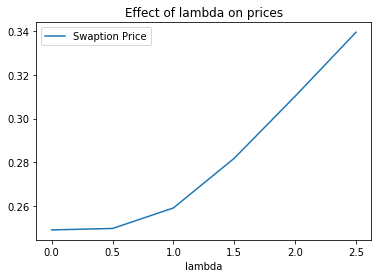

In [11]:
lmbdas = np.arange(0,3,0.5)

swaptions1 = [swaption(M,N,T0,K,l,a,b,chi,bonds,maturities) for l in lmbdas]

plot2D(lmbdas,swaptions1,'lambda','Swaption Price','Effect of lambda on prices')

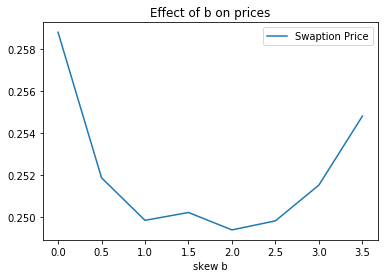

In [13]:
b_val = np.arange(0,4,0.5)

swaptions2 = [swaption(M,N,T0,K,lmbda,a,b,chi,bonds,maturities) for b in b_val]

plot2D(b_val,swaptions2,'skew b','Swaption Price','Effect of b on prices')

**Observation: As expected, an increase in $\lambda$ and b leads to an increase in the short rate volatility and then in the swaption volatility.**

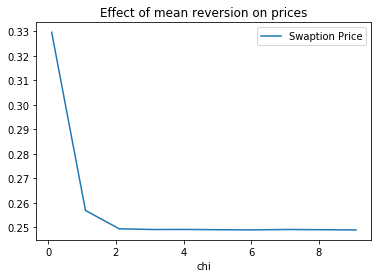

In [14]:
mean_reversion_val = np.arange(0.1,10,1)

swaptions = [swaption(M,N,T0,K,lmbda,a,b,mr,bonds,maturities) for mr in mean_reversion_val]

plot2D(mean_reversion_val,swaptions,'chi','Swaption Price','Effect of mean reversion on prices')

**Remark:** One observes that the swaption volatility decreases as the mean reversion increases as it is said p. 553 in Piterbarg. Indeed, the mean reversion parameter tends to keep the factor x around a mean level

## Implied volatility

Assume that the swap rate $S$ is log-normal. We have the following diffusion $$\mathrm{d}S_{T0,...,T_N}(t) = S_{T0,...,T_N}(t)\sigma \ \mathrm{d}W_t$$ because it has to be a martingale under $\mathbb{Q}^A$ where $$\frac{\mathrm{d}\mathbb{Q}^A}{\mathrm{d}\mathbb{Q}}\Big| _{\mathcal{F}_t} = \frac{A(t)}{A(0)} e^{-\int_{0}^{t} r(s) \ \mathrm{d}s}$$

Hence $$\begin{array}{ll} V_0 &= \mathbb{E}_{\mathbb{Q}}\Big[ e^{-\int_{0}^{t} r(s) \ \mathrm{d}s} Swap(T_0)^+ \Big]
= A(0) \mathbb{E}_{\mathbb{Q}^A}\Big[ \big(S(T_0) -K \big) \mathbb{1}_{S(T_0)>K} \Big] \end{array}$$

Let $$\frac{\mathrm{d}\tilde{\mathbb{Q}}}{\mathrm{d}\mathbb{Q}^A} = \frac{S(T_0)}{\mathbb{E}[S(T_0)]} = e^{-\frac{\sigma^2}{2}T_0 + \sigma W_{T_0}}$$ and by Girsanov's Theorem, $$\tilde{W}_t = W^A_t - \sigma t$$ is a Brownian motion under $\tilde{\mathbb{Q}}$.

It leads to a Black Scholes formula by:
$$\begin{array}{ll} V_0 &= A(0)S(0) \tilde{\mathbb{Q}} \Big( e^{\frac{\sigma^2}{2}T_0 + \sigma \tilde{W}_{T_0}} > K \Big) \ -K A(0) \mathbb{Q}^A \Big( \sigma W_{T_0} > \ln{\frac{K}{S(0)}} + \frac{\sigma^2}{2} T_0 \Big) \\
&= \boxed{A(0)S(0) \Phi(d^+) \ -KA(0) \Phi(d^-)}
\end{array}$$

$$\left\{
    \begin{array}{ll}
       d^+ &= \frac{\ln{\frac{S(0)}{K}} + \frac{\sigma^2}{2} T_0}{\sigma \sqrt{T_0}} \\
       d^- &= d^+ - \sigma \sqrt{T_0}
    \end{array}
\right.$$

In particular, $\frac{\partial d^+}{\partial \sigma} = \frac{\partial d^-}{\partial \sigma} + \sqrt{T_0}$ and 
$$vega = \frac{\partial V_0}{\partial \sigma} = A(0)S(0) \frac{\partial d^+}{\partial \sigma} \phi(d^+) \ -K A(0) \frac{\partial d^-}{\partial \sigma} \phi(d^-) \\
= A(0)S(0) \sqrt{\frac{T_0}{2\pi}} e^{-\frac{(d^+)^2}{2}}$$ ($\Phi$ is the cdf of the standard normal law and $\phi$ its density function.)

First view of Black scholes prices to be sure that the pricing formula is right and that the asymptotic behavior is the expected one, i.e $V_0 \rightarrow_{\sigma \to \infty} A(0)S(0)$

SO*A0= 0.5954216631743912


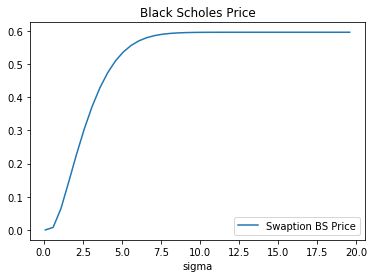

In [12]:
#Black Scholes Price

def Price_BS(S0,A0,T0,K,sigma):
    d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
    return S0*A0* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))

T0 = maturities[0]
nb_maturities = maturities.size
A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
S0 = (bonds[0]-bonds[-1])/A0
sigma_val = np.arange(0.1,20,0.5)
BS_prices = [Price_BS(S0,A0,T0,2*S0,s) for s in sigma_val]
print('SO*A0=',S0*A0)


plot2D(sigma_val,BS_prices,'sigma','Swaption BS Price','Black Scholes Price')

### Newton-Raphson algorithm

The simple Newton-Raphson algorithm, applied to find the zero of the function $\sigma \rightarrow V_0(\sigma) - \hat{V}$ where $\hat{V}$ is the observed marked to market value of the swaption, is written:

$$\left\{
    \begin{array}{ll}
       \sigma_0 \quad \text{chosen}\\
       \sigma_{n+1} = \sigma_n - \bigg( \frac{V_0(\sigma_n) - \hat{V}}{\frac{\partial V_0}{\partial \sigma}(\sigma_n)} \bigg)
    \end{array}
\right.$$

In [13]:
def Newton_Raphson(sigma0, nb_it, Mtm, bonds, K, maturities):
    sigma = sigma0
    T0 = maturities[0]   
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0
    
    for i in range(nb_it):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        price_BS = (bonds[0]-bonds[-1])* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))
        derivative = (bonds[0]-bonds[-1])*np.sqrt(T0/(2*np.pi))*np.exp(-0.5*d**2)
        sigma = sigma - (price_BS-Mtm)/derivative
        #print("Sigma, derivative =",sigma, derivative)
    return sigma

Newton_Raphson(0.1,10,0.05,bonds,2,maturities)

0.5019064713365248

There is some instability with the Newton-Raphson algorithm because the derivative of the Black Scholes price tends to be very small.

### Dichotomie

In [14]:
def bissectrice(nb_it, Mtm, bonds, K, maturities):
    T0 = maturities[0]   
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0

    x = 0
    y = 1
    for i in range(nb_it):
        z = (x+y)/2
        sigma = z/(1-z)
        price_BS = Price_BS(S0,A0,T0,K,sigma)

        if(Mtm > price_BS):
            x = z
        else:
            y = z
    z = (x+y)/2
    return z/(1-z)

bissectrice(10,0.05,bonds,2,maturities)

0.5025678650036683

In [15]:
# méthode bissectrice de Python

def biss_python(Mtm, bonds, K, maturities):
    T0 = maturities[0] 
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0
    return opt.bisect(lambda x: Price_BS(S0,A0,T0,K,x) - Mtm, 0.01, 10)


### Root finding by Python's algorithm

In [16]:
#Brent's method

def Brent(Mtm, bonds, K, maturities):
    T0 = maturities[0] 
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0
    f = lambda x: Price_BS(S0,A0,T0,K,x) - Mtm
    return opt.brentq(f, 0.001, 20)


This algorithm is efficient but stops wether $f(a)f(b)>0$ at one moment

In [17]:
#Essai sur un prix BS avec sigma connu et comparaison des méthodes

sigma = 0.5
nb_maturities = maturities.size
A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
S0 = (bonds[0]-bonds[-1])/A0 
Market_price = Price_BS(S0,A0,T0,2,sigma)

New_vol = Newton_Raphson(0.1, 5, Market_price, bonds, 2, maturities)
bissec_vol = bissectrice(10, Market_price, bonds, 2, maturities)
python_vol = biss_python(Market_price,bonds,2,maturities)
Brent_vol = Brent(Market_price,bonds,2,maturities)
print("Vol BS:", sigma,"Implied vol Newton:",New_vol,"Implied vol Bissec:",bissec_vol,"Implied vol python", python_vol,"Implied vol Brent: ",Brent_vol
)

Vol BS: 0.5 Implied vol Newton: 0.50000042343507 Implied vol Bissec: 0.5003663003663004 Implied vol python 0.5000000000008197 Implied vol Brent:  0.49999999999992195


### Effect of K

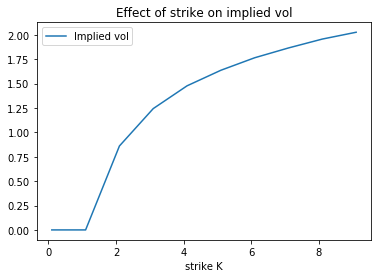

In [21]:
strikes = np.arange(0.1,10,1)
impli_vol = [bissectrice(10,0.1,bonds,k,maturities) for k in strikes]

plot2D(strikes,impli_vol,'strike K','Implied vol','Effect of strike on implied vol')

**Explanation:** One should have an implied volatility surface which is decreasing with respect to strike K, but this phenomenon is justified by the fact that input price is the same for all values of K and is 'randomly' chosen. Indeed Black & Scholes price is decreasing with respect to K: $$\frac{\partial V_0}{\partial K} = A(0)S(0) \frac{\partial d^+}{\partial K} \phi(d^+) \ -A(0)K \frac{\partial d^-}{\partial K} \phi(d^-) - A(0) \Phi(d^-)$$

And $\frac{\partial d^+}{\partial K} = \frac{\partial d^-}{\partial K} = \frac{-1}{\sigma \sqrt{T_0}K}$
So $$\frac{\partial V_0}{\partial K} = \frac{-A(0)}{\sigma\sqrt{T_0}} \Big( \frac{S(0)}{K}\phi(d^+)-\phi(d^+-\sigma\sqrt{T_0}) \Big) \ -A(0) \Phi(d^-) = -A(0) \Phi(d^-) \ \le 0$$

Hence if $K_1 \le K_2, \quad \hat{V} = V_0(K_1,\sigma_1) = V_0(K_2,\sigma_2)$ then $\sigma_2 \ge \sigma_1$ which explains the behavior of the curve above.

One should rather calculate the Monte Carlo Swaption Price for each strike instead of plotting the implied volatility calculated on a single Price

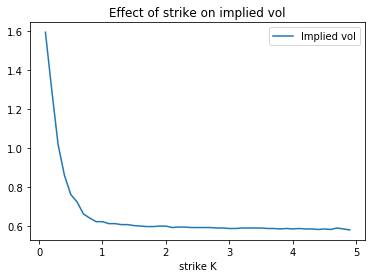

In [22]:
#MC(K) = BS(K,sigma)
strikes = np.arange(0.1,5,0.1)
implied_vol = []
for k in strikes:
    Price = swaption(M,N,T0,k,lmbda,a,b,chi,bonds,maturities)
    implied_vol.append(bissectrice(10,Price,bonds,k,maturities))

plot2D(strikes,implied_vol,'strike K','Implied vol','Effect of strike on implied vol')

**Remark:** Here one observes an implied volatility curve which is decreasing with respect to the strike K as expected. However no smile phenomenon is remarkable here and higher values of the strike implies more unstability in the inversion algorithm and the observations would have no sense.

### Effect of T0

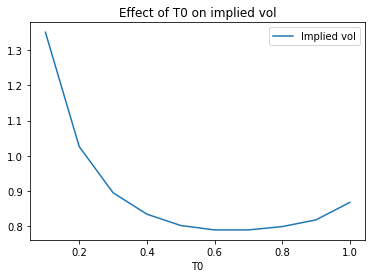

In [38]:
T0s = np.arange(0.1,1.1,0.1)
impli_vol = [bissectrice(10,0.1,[np.exp(-r*m) for m in np.arange(t,5)],2,np.arange(t,5)) for t in T0s]

plot2D(T0s,impli_vol,'T0','Implied vol','Effect of T0 on implied vol')

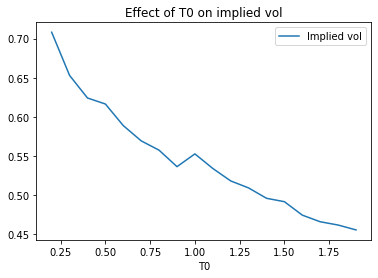

In [24]:
# MC(T0) = BS(T0,sigma)
T0s = np.arange(0.2,2,0.1)
implied_vol = []
for T in T0s:
    tenor = np.arange(T,5)
    ZC_bonds = [np.exp(-r*m) for m in tenor]
    Price = swaption(M,N,T,K,lmbda,a,b,chi,ZC_bonds,tenor)
    implied_vol.append(bissectrice(10,Price,ZC_bonds,K,tenor))
    
plot2D(T0s,implied_vol,'T0','Implied vol','Effect of T0 on implied vol')

**Remark:** The volatility surface observed in the market is in general decreasing with respect to the maturity, as we can observe here

### Reliability of bissection method
One will input a swaption price calculated by the Black & Scholes formula for a known volatility. The generated surface is then supposed to be flat and equal to this level of volatility. It is a way to check if the inversion method is unstable somewhere. $$V_0^{BS}(T0,K,\sigma) = \hat{V}$$

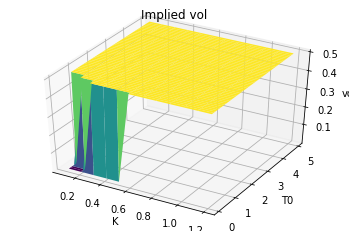

In [18]:
#from a BS price with sigma known --> flat curve in theory
T0s = np.arange(0.1,1.3,0.1)
strikes = np.arange(0.1,5,0.1)
X,Y = np.meshgrid(T0s, strikes)
sigma = 0.5
Z = np.zeros((strikes.size,T0s.size))
i,j= 0,0
for k in strikes:
    for t in T0s:
        maturities = np.arange(t,5)
        bonds = [np.exp(-r*m) for m in maturities]
        nb_maturities = maturities.size
        A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
        S0 = (bonds[0]-bonds[-1])/A0
        Price = Price_BS(S0,A0,t,k,sigma)
        vol = bissectrice(10,Price, bonds, k, maturities)
        Z[i][j] = vol
        #Z[i][j] = Brent(Price_BS(S0,A0,t,k,sigma), bonds, k, maturities)
        #print("K=",k,"T0=",t,"Price=",Price,"vol=",vol,"Zi,j=",Z[i][j])
        j = (j+1)%T0s.size
    i+=1
        
plot3D(X,Y,Z,300)

**Remark:** It can be osbserved that the implied volatility surface is flat almost everywhere. However implied volatility seems to vanish for low levels of $K$ and $T_0$. The lower the input volatility is, the more important is the unstability.

Now one will inverse a price given by the Monte Carlo method described before. $$V_0^{BS}(T0,K,\sigma) = V_0^{MC}(T_0,K)$$

In [19]:
#construction of an implied volatility surface

def construct_surface(strikes,T0s,M,N,lmbda,a,b,chi):
    surface = np.zeros((T0s.size,strikes.size))
    i,j= 0,0
    for t in T0s:
        maturities = np.arange(t,5)
        bonds = [np.exp(-r*m) for m in maturities]
        for k in strikes:
            Price = swaption(M,N,t,k,lmbda,a,b,chi,bonds,maturities)
            surface[i][j] = bissectrice(10,Price, bonds, k, maturities)
            j = (j+1)%strikes.size
        i+=1
    return surface

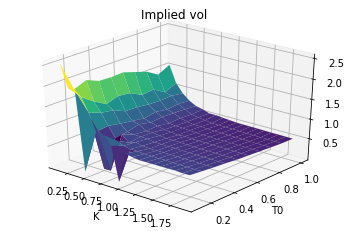

In [64]:
# plot of the implied volatility surface with Monte Carlo Prices as input prices

strikes = np.arange(0.1,2,0.1)
T0s = np.arange(0.1,1.1,0.1)
X,Y = np.meshgrid(strikes, T0s)
Z = construct_surface(strikes,T0s,M,N,lmbda,a,b,chi)
        
plot3D(X,Y,Z,-50)

**Idea:** One can observe some anomalies in the region around $(T_0,K) = (0.2 Y, 0.5)$ which could be generated by the random simulation made during the pricing step. Indeed with this version of the algorithm, one has generated $M$ samples of $(x,y,I)$ for each point of the grid. Even with a high value of $M$, differences could happen, that's why one would prefer to generate only one time $M$ samples of $(x,y,I)$ and do the Monte Carlo pricing with these samples for each point of the grid.

## New surface building

In [20]:
#One simulate a unique time M samples (x,y,I)

def simul2(x0,y0,I0,lmbda,a,b,chi,delta):
    N = delta.size
    (x,y,I) =(x0,y0,I0)
    for i in range(N-1):
        delta_i = delta[i+1]-delta[i]
        sigma_i = lmbda*(a+b*x)
        Z = float(np.random.standard_normal(1))
        I = I - x*delta_i
        x = x +(y-chi*x)*delta_i + sigma_i*math.sqrt(delta_i)*Z
        y = y + (sigma_i**2 -2*chi*y)*delta_i
    return [x,y,I]

def MC(M,sim,K,chi,bonds,maturities,exec_time=False):
    Monte_Carlo = 0
    for m in range(M):
        (x,y,I) = (sim[m][0],sim[m][1],sim[m][2])
        Monte_Carlo += np.exp(I)*payoff_swaption(maturities,bonds,x,y,chi,K)
        
    return Monte_Carlo/M

def construct_surface2(strikes,T0s,M,N,lmbda,a,b,chi):
    surface = np.zeros((T0s.size,strikes.size))
    sim = [(0,0,0)] * M
    i,j= 0,0
    for t in T0s:
        if i==0:
            delta = np.linspace(0,t,N+1)
        else:
            delta = np.linspace(T0s[i-1],T0s[i],N+1)
            
        sim = [simul2(sim[m][0],sim[m][1],sim[m][2],lmbda,a,b,chi,delta) for m in range(M)]
        maturities = np.arange(t,5)
        bonds = [np.exp(-r*m) for m in maturities]
        for k in strikes:
            Price = MC(M,sim,k,chi,bonds,maturities)
            surface[i][j] = bissectrice(10,Price, bonds, k, maturities)
            j = (j+1)%(strikes.size)
        i+=1
    return surface

In [68]:
t1=time()
strikes = np.arange(0.1,2,0.1)
T0s = np.arange(0.1,1.1,0.1)
X,Y = np.meshgrid(strikes, T0s)
Z = construct_surface2(strikes,T0s,M,N,lmbda,a,b,chi)
t2=time()
print("Exec time:",t2-t1)

Exec time: 492.00112795829773


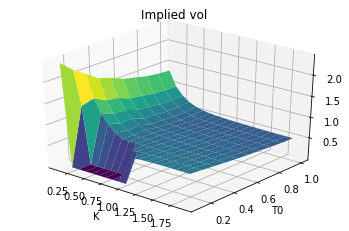

In [69]:
plot3D(X,Y,Z,-50)

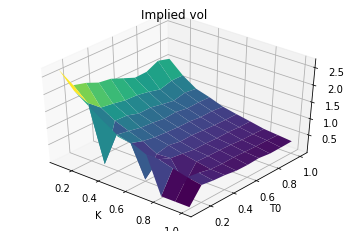

In [21]:
#Tests with different a

strikes = np.arange(0.1,1.1,0.1)
T0s = np.arange(0.1,1.1,0.1)
X,Y = np.meshgrid(strikes, T0s)
Z = construct_surface(strikes,T0s,M,N,lmbda,1,b,chi)
        
plot3D(X,Y,Z,-50)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


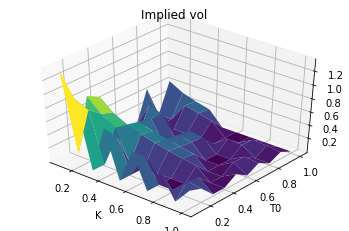

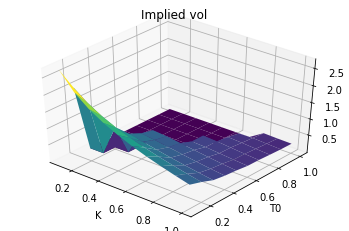

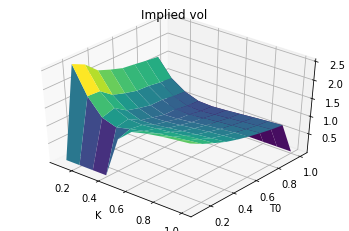

In [55]:
X,Y = np.meshgrid(strikes, T0s)
Z2 = construct_surface2(strikes,T0s,M,N,lmbda,0,b,chi)
Z3 = construct_surface2(strikes,T0s,M,N,lmbda,1,b,chi)
Z4 = construct_surface2(strikes,T0s,M,N,lmbda,3,b,chi)
plot3D(X,Y,Z2,-50)
plot3D(X,Y,Z3,-50)
plot3D(X,Y,Z4,-50)

## Pricing by Gaussian swap rate approximation ( p.422 10.1.3.2)

A simple way to approximate the swaption price is to consider the swap rate purely gaussian such that $\mathrm{d}S_t = \sigma \ \mathrm{d}W_t$. In this case, one has $$\begin{array}{ll} \mathbb{E}\Big[ (S_T - K)^+ \ | \mathcal{F}_t\Big] &= \mathbb{E}\Big[ (S_T - K)^+ \ | S_t=S\Big] \\
&= \mathbb{E}\Big[ \Big(S - K + \sigma(W_T-W_t)\Big) \mathbb{1}_{S_T>K} \ | S_t=S\Big] \\
&= (S-K) \Phi\Big( \frac{S-K}{\sigma \sqrt{T-t}}\Big) + \sigma \sqrt{T-t} \int_{\frac{K-S}{\sigma \sqrt{T-t}}}^{\infty} \frac{x}{\sqrt{2\pi}} e^{-\frac{x^2}{2}} \, \mathrm{d}x \\
&= (S-K) \Phi( d ) + \sigma \sqrt{T-t} \phi(d)
\end{array}$$

Under the annuity measure, the Ito's lemma implies $\mathrm{d}S_t = \frac{\partial S}{\partial x}(t,x(t),y(t)) \ \sigma_r(t,x(t)) \ \mathrm{d}W_t^A$ and one let $q = \frac{\partial S}{\partial x}$.

Hence $$\boxed{V_0 \approx A(0) \Big[\big(S(0) -K \big) \Phi(d) \ + \ \sqrt{v} \phi(d) \Big] \\
d= \frac{S(0)-K}{\sqrt{v}} \quad v = \int_{0}^{T_0} q(t,x(t),y(t))^2 \ \sigma_r(t,x(t))^2 \ \mathrm{d}t}$$

Where $$q(t,x) = -\frac{P(t,T_0,x) G(t,T_0) - P(t,T_N,x)G(t,T_N)}{A(t,x)} \ + \ \frac{S(t,x)}{A(t,x)}\sum_{i=0}^{N-1} \tau_i P(t,T_{i+1},x) G(t,T_{i+1})$$

The problem here is to find an approximated value of the integral which depends of the whole path of $t \rightarrow x(t)$ on $[0,T_0]$.

As one simulates $x$ and $y$ thanks to a discretization scheme, one will approximate $x$ and $y$ as piecewise constant functions.

With $0=t_0 < t_1 < ... < t_N = T_0$, let $x_i = x(t_i) \ , \ y_i = y(t_i)$.

$$\int_{0}^{T_0} q(t,x(t),y(t))^2 \ \sigma_r(t,x(t))^2 \ \mathrm{d}t = \sum_{i=0}^{N-1} \int_{t_i}^{t_{i+1}} q(t,x(t),y(t))^2 \ \sigma_r(t,x(t))^2 \ \mathrm{d}t \\
\approx \sum_{i=0}^{N-1} \int_{t_i}^{t_{i+1}} q(t,x_i,y_i)^2 \ \sigma_r(t,x_i)^2 \ \mathrm{d}t \\
= \lambda^2 \sum_{i=0}^{N-1} (a+bx_i)^2 \int_{t_i}^{t_{i+1}} q(t,x_i,y_i)^2 \ \ \mathrm{d}t$$

And each integral above will be numerically computed by scipy.integrate algorithm

In [23]:
def q(t,x,y,maturities,chi):
    A,B = 0,0
    for n in range(maturities.size-1):
        g = G(t,maturities[n+1],chi)
        A += (maturities[n+1]-maturities[n])*np.exp(-r*(maturities[n+1]-t))*np.exp(-1*g*x-0.5*y*g**2)
        B += (maturities[n+1]-maturities[n])*np.exp(-r*(maturities[n+1]-t))*np.exp(-1*g*x-0.5*y*g**2)*g
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    PT0 = (np.exp(-r*(maturities[0]-t))*np.exp(-1*g0*x-0.5*y*g0**2))
    PTN = (np.exp(-r*(maturities[-1]-t))*np.exp(-1*gN*x-0.5*y*gN**2))
    qt = (PTN*gN - PT0*g0)/A + (PT0-PTN)*B/(A**2)
    return qt

In [34]:
#Swaption Pricing in the gaussian swap rate approximation

def swaption_gauss(N,K,maturities,lmbda,a,b,chi):
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*np.exp(-r*maturities[i+1]) for i in range(0,nb_maturities-1)])
    S0 = (np.exp(-r*maturities[0])-np.exp(-r*maturities[-1]))/A0
    
    #calcul of v
    v = 0
    x,y = 0,0
    delta = np.linspace(0,maturities[0],N+1)
    for i in range(N):
        sigma_i = lmbda*(a+b*x)
        delta_i = delta[i+1]-delta[i]
        
        #add the approximated integral to v
        integral = integrate.quad(lambda t: q(t,x,y,maturities,chi)**2,delta[i],delta[i+1])[0]
        v += sigma_i**2 * integral
        
        #update sigma,x,y
        Z = float(np.random.standard_normal(1))
        x = x +(y-chi*x)*delta_i + sigma_i*math.sqrt(delta_i)*Z
        y = y + (sigma_i**2 -2*chi*y)*delta_i
        
    d = (S0-K)/np.sqrt(v)
    return A0*((S0-K)*stats.norm.cdf(d) + np.sqrt(v)*gaussian_density(d))

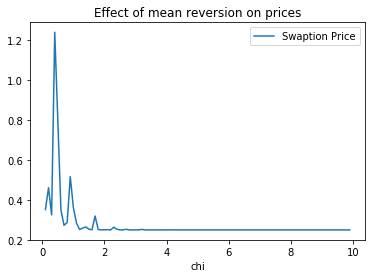

In [53]:
N = 50
mean_reversion_val = np.arange(0.1,10,0.1)

swaptions = [swaption_gauss(N,K,maturities,lmbda,a,b,mr) for mr in mean_reversion_val]

plot2D(mean_reversion_val,swaptions,'chi','Swaption Price','Effect of mean reversion on prices')

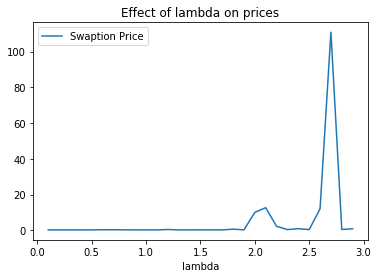

In [49]:
lmbdas = np.arange(0.1,3,0.1)

swaptions1 = [swaption_gauss(N,K,maturities,l,a,b,chi) for l in lmbdas]

plot2D(lmbdas,swaptions1,'lambda','Swaption Price','Effect of lambda on prices')

## $\chi$ piecewise constant 
(see "One factor Gaussian short rate model implementation", Caspers)

$$\chi(t) = \sum_{i=0}^{N-1} \chi_i \ \mathbb{1}_{t \in [t_i,t_{i+1}[}$$

Then closed formulas for $G$ and $y$ will change.
One notes $U(t) = \inf { \{i \in [|0,N|], \ t_i \ge t\}}$ and $l(t) = \sup { \{i \in [|0,N|], \ t_i \le t\}}$

**changes for G:** 
$$e^{-\int_{t}^{u} \chi(s) \ \mathrm{d}s} = \prod_{i=l(t)}^{U(u)-1} e^{-\chi_{i}\left(t_{i+1} \wedge u-t_i \vee t\right)}$$

$$G\left(t, T \right)=\sum_{i=l(t)}^{U\left(T\right)-1} \int_{t_i \vee t}^{T \wedge t_{i+1}}\left(\prod_{j=l(t)}^{i-1} e^{-\kappa_{j}\left(t_{j+1}-t_j \vee t\right)}\right) e^{-\kappa_{i}\left(u-t_i \vee t\right)} d u
$$